In [1]:
using CSV
using DataFrames
using StatsPlots
using Dates
using Statistics
using MLJScientificTypes
using HypothesisTests
using StatsBase
using CategoricalArrays
default(fmt=:png)
gr()

Plots.GRBackend()

# Overview

In [2]:
df = CSV.read("superstore_dataset2011-2015.csv", DataFrame)
df = select(df, Not(["Row ID", "Order ID", "Customer Name", "Postal Code", "Product Name"]))
first(df, 5)

,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State
,String,String,String,String,String,String,String
1,1/1/2011,6/1/2011,Standard Class,TB-11280,Consumer,Constantine,Constantine
2,1/1/2011,8/1/2011,Standard Class,JH-15985,Consumer,Wagga Wagga,New South Wales
3,1/1/2011,5/1/2011,Second Class,AT-735,Consumer,Budapest,Budapest
4,1/1/2011,5/1/2011,Second Class,EM-14140,Home Office,Stockholm,Stockholm
5,1/1/2011,8/1/2011,Standard Class,JH-15985,Consumer,Wagga Wagga,New South Wales


Standardize some field

In [3]:
const CATEGORICALS = [:Segment, :City, :State, :Country, :Market, :Region, :Category, :SubCategory]

8-element Vector{Symbol}:
 :Segment
 :City
 :State
 :Country
 :Market
 :Region
 :Category
 :SubCategory

In [4]:
df = let data = df
    # If this cell was ran before, return the data
    if "OrderDate" in names(data)
        return data
    end
    # Convert date string to real datetime, which is easier to process
    convertdate(datestring) = if occursin("/", datestring)
        Date(datestring, dateformat"dd/mm/yyyy")
    else
        Date(datestring, dateformat"dd-mm-yyyy")
    end
    OrderDate = map(convertdate, data[!, "Order Date"])
    ShipDate = map(convertdate, data[!, "Order Date"])
    data = select(data, Not(["Order Date", "Ship Date"]))
    data.OrderDate = OrderDate
    data.ShipDate = ShipDate
    data.Year = map(year, OrderDate)
    data.Month = map(month, OrderDate)
    data.Quater = map(quarterofyear, OrderDate)
    
    # Also rename some columns, remove weird character
    for name in names(data)
        rename!(data, name => replace(name, r"[-\s,./;']" => ""))
    end
    
    # Ordinal data
    shipmodes = ["Standard Class", "Second Class", "First Class", "Same Day"]
    orderpriorities = ["Medium", "High", "Critical", "Low"]
    foreach([:ShipMode => shipmodes, :OrderPriority => orderpriorities]) do (name, order)
        data[!, name] = map(datum -> findfirst(isequal(datum), order), data[!, name])
    end
    
    # Nominal data
    #   Segment       │ CategoricalValue{String, UInt32} │ Multiclass{3}     │
    # │ City          │ CategoricalValue{String, UInt32} │ Multiclass{3636}  │
    # │ State         │ CategoricalValue{String, UInt32} │ Multiclass{1094}  │
    # │ Country       │ CategoricalValue{String, UInt32} │ Multiclass{147}   │
    # │ Market        │ CategoricalValue{String, UInt32} │ Multiclass{7}     │
    # │ Region        │ CategoricalValue{String, UInt32} │ Multiclass{13}    │
    # │ ProductID     │ CategoricalValue{String, UInt32} │ Multiclass{10292} │
    # │ Category      │ CategoricalValue{String, UInt32} │ Multiclass{3}     │
    # │ SubCategory  
    foreach(CATEGORICALS) do name
        data[!, name] = categorical(data[!, name])
    end
    
    sort(data, :OrderDate)
end
first(df, 5)

,ShipMode,CustomerID,Segment,City,State,Country,Market
,Int64,String,Cat…,Cat…,Cat…,Cat…,Cat…
1,1,TB-11280,Consumer,Constantine,Constantine,Algeria,Africa
2,1,JH-15985,Consumer,Wagga Wagga,New South Wales,Australia,APAC
3,2,AT-735,Consumer,Budapest,Budapest,Hungary,EMEA
4,2,EM-14140,Home Office,Stockholm,Stockholm,Sweden,EU
5,1,JH-15985,Consumer,Wagga Wagga,New South Wales,Australia,APAC


In [5]:
let df_ = coerce(df; :OrderPriority => :OrderPriority => OrderedFactor)
    schema(df_)
end

┌───────────────┬──────────────────────────────────┬──────────────────┐
│ _.names       │ _.types                          │ _.scitypes       │
├───────────────┼──────────────────────────────────┼──────────────────┤
│ ShipMode      │ Int64                            │ Count            │
│ CustomerID    │ String                           │ Textual          │
│ Segment       │ CategoricalValue{String, UInt32} │ Multiclass{3}    │
│ City          │ CategoricalValue{String, UInt32} │ Multiclass{3636} │
│ State         │ CategoricalValue{String, UInt32} │ Multiclass{1094} │
│ Country       │ CategoricalValue{String, UInt32} │ Multiclass{147}  │
│ Market        │ CategoricalValue{String, UInt32} │ Multiclass{7}    │
│ Region        │ CategoricalValue{String, UInt32} │ Multiclass{13}   │
│ ProductID     │ String                           │ Textual          │
│ Category      │ CategoricalValue{String, UInt32} │ Multiclass{3}    │
│ SubCategory   │ CategoricalValue{String, UInt32} │ Multiclass{

# Plots

In [50]:
?groupedbar

search: groupedbar groupedbar! groupedboxplot groupedboxplot! groupedhist



No documentation found.

`StatsPlots.groupedbar` is a `Function`.

```
# 1 method for generic function "groupedbar":
[1] groupedbar(args...; kw...) in StatsPlots at /home/hung/.cache/julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:357
```


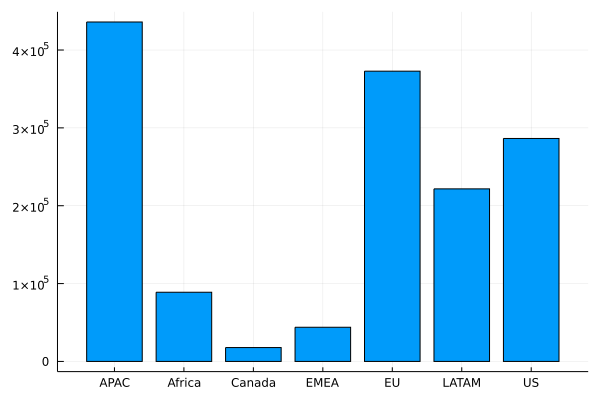

In [59]:
let profit_by_market = combine(groupby(df, :Market), :Profit => sum => :Profit)
    bar(string.(profit_by_market.Market), profit_by_market.Profit, label = false)
end

# Alg tryout
---

## Apriori

In [6]:
function support(thing, things)
    count(map(isequal(thing), things)) / length(things)
end
function confidence(rule, things)
    thing1, thing2 = rule
    st1 = support(thing1, things)
    st2 = support(thing2, things)
    (st1 + st2) / st1
end
function lift(rule, things)
    thing1, thing2 = rule
    st1 = support(thing1, things)
    st2 = support(thing2, things)
    (st1 + st2) / (st1 * st2)
end

lift (generic function with 1 method)

In [7]:
@show support("Furniture", df.Category)
@show confidence("Technology" => "Furniture", df.Category)
@show lift("Technology" => "Furniture", df.Category)

support("Furniture", df.Category) = 0.19255215441606552
confidence("Technology" => "Furniture", df.Category) = 1.9738684547874965
lift("Technology" => "Furniture", df.Category) = 10.251084755574189


10.251084755574189

## CramerV Association

In [64]:
function chisq(A, B)
    @assert length(A) == length(B)
    countA = countmap(A)
    countB = countmap(B)
    countAB = countmap(zip(A, B))
    chi = 0.0
    n = length(A)
    for ((i, j), nij) in countAB
        ni = countA[i]
        nj = countB[j]
        aux = ni * nj / n
        chi = chi + (nij - aux)^2 / aux
    end
    return chi
end
function crammerv(A, B; corrected=true)
    r = (length ∘ unique)(A)
    k = (length ∘ unique)(B)
    χ² = chisq(A, B)
    n = length(A)
    φ² = χ² / n
    if corrected
        φ² = max(0, φ² - (k - 1) * (r - 1) / (n - 1))
        k = k - (k - 1)^2 / (n - 1)
        r = r - (r - 1)^2 / (n - 1)
    end
    return sqrt(φ² / min(k - 1, r - 1))
end

crammerv (generic function with 1 method)

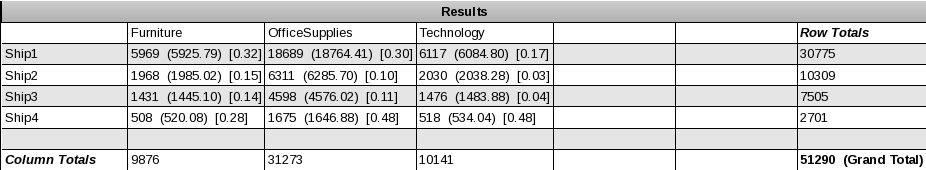

In [74]:
@show chisq(df.Category, df.ShipMode)
@show crammerv(df.Category, df.ShipMode)

chisq(df.Category, df.ShipMode) = 2.5977282981411443
crammerv(df.Category, df.ShipMode) = 0.0


0.0

In [60]:
groupby(df, :City)[1]

,ShipMode,CustomerID,Segment,City,State,Country,Market
,Int64,String,Cat…,Cat…,Cat…,Cat…,Cat…
1,1,TB-21520,Consumer,Aachen,North Rhine-Westphalia,Germany,EU
2,1,MA-17995,Home Office,Aachen,North Rhine-Westphalia,Germany,EU
3,1,DJ-13630,Consumer,Aachen,North Rhine-Westphalia,Germany,EU
4,4,JC-15340,Consumer,Aachen,North Rhine-Westphalia,Germany,EU
5,1,MO-17500,Consumer,Aachen,North Rhine-Westphalia,Germany,EU
6,1,MO-17500,Consumer,Aachen,North Rhine-Westphalia,Germany,EU
7,1,MO-17500,Consumer,Aachen,North Rhine-Westphalia,Germany,EU
8,1,MO-17500,Consumer,Aachen,North Rhine-Westphalia,Germany,EU
9,1,MO-17500,Consumer,Aachen,North Rhine-Westphalia,Germany,EU


In [65]:
for (cat1, cat2) in Iterators.product(CATEGORICALS, CATEGORICALS)
let df = groupby(df, :City)[1]
        if !isequal(cat1, cat2)
            cr = crammerv(df[!, cat1], df[!, cat2])
            if cr >= 0.3 
                @show (cat1, cat2) => cr
            end
        end
    end
end

(cat1, cat2) => cr = (:SubCategory, :Category) => 0.7350419735746121
(cat1, cat2) => cr = (:Category, :SubCategory) => 0.7350419735746121


In [45]:
let A = df.ShipMode
    B = levelcode.(df.Category)
    count = countmap(zip(A, B))
    N = length(unique(A))
    M = length(unique(B))
    z = zeros(Int, N, M)
    for I in CartesianIndices(z)
        z[I] = count[Tuple(I)]
    end
    z
end

4×3 Matrix{Int64}:
 5969  18689  6117
 1968   6311  2030
 1431   4598  1476
  508   1675   518

## Gower distance + PAM

In [9]:
using Clustering
using Base.Threads

In [12]:
function gower(x::Number, y::Number, Rf)::Float16
    abs(x - y) / Rf
end
function gower(x::CategoricalValue, y::CategoricalValue)::Float16
    x == y ? 1 : 0
end
function gower(df::AbstractDataFrame, name)::Matrix{Float16}
    data = df[!, name]
    distance = if elscitype(data) <: Multiclass
        map(Iterators.product(data, data)) do (di, dj)
            gower(di, dj)
        end
    elseif elscitype(data) <: Infinite
        Rf = abs(maximum(data) - minimum(data))
        map(Iterators.product(data, data)) do (di, dj)
            gower(di, dj, Rf)
        end
    else
        nrows = size(df, 1)
        zeros(nrows, nrows)
    end
end
function gower(df::AbstractDataFrame)
    nrows = size(df, 1)
    dist = zeros(Float16, nrows, nrows)
    @threads for name in names(df)
        data = df[!, name]
        T = elscitype(data)
        if T <: Multiclass || T <: Continuous
            dist = dist + gower(df, name)
        end
    end
    return dist / maximum(dist)
end

gower (generic function with 4 methods)

In [24]:
kmedoids(gower(groupby(df, :Month)[1]), 10)

KmedoidsResult{Float16}([964, 6, 1686, 2385, 288, 469, 900, 2592, 1122, 1924], [8, 4, 4, 7, 9, 9, 9, 8, 2, 9  …  1, 3, 3, 3, 1, 1, 1, 1, 1, 1], Float16[0.0001794, 0.0001606, 0.00123, 0.0003972, 0.003223, 0.006676, 0.002598, 0.005985, 0.0002823, 0.004795  …  0.0002083, 0.0001655, 0.0002052, 7.32e-5, 0.000151, 4.8e-6, 0.0001079, 0.0001631, 0.0001737, 0.0001704], [1062, 154, 381, 56, 42, 190, 133, 182, 568, 267], 5.075041890144348, 200, false)

In [16]:
kmd_result = let dist = gower(groupby(df, :Year)[1])
    kmedoids(dist, 4)
end

KmedoidsResult{Float16}([1177, 509, 11035, 4304], [2, 3, 2, 3, 3, 3, 2, 4, 3, 3  …  4, 4, 4, 4, 4, 1, 4, 4, 4, 4], Float16[0.0157, 0.01037, 0.00418, 0.02077, 0.010414, 0.002888, 0.001858, 0.001153, 0.0036, 0.001416  …  0.000564, 0.0006156, 0.000701, 0.000554, 0.00062, 0.0001118, 0.000581, 0.0007076, 0.0007133, 0.0006247], [1750, 2041, 2860, 7148], 31.82560783624649, 200, false)

In [22]:
kmd_result.converged

false

┌ Warning: Indices Base.OneTo(13799) of attribute `seriescolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(13799) of attribute `linecolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(13799) of attribute `fillcolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(13799) of attribute `markercolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(13799) of attribute `seriescolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(13799) of attribute `linecolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packag

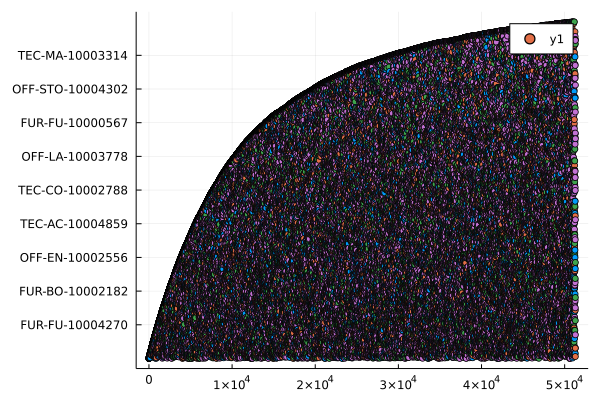

┌ Warning: Indices Base.OneTo(13799) of attribute `seriescolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(13799) of attribute `linecolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(13799) of attribute `fillcolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(13799) of attribute `markercolor` does not match data indices 1:51290.
└ @ Plots /home/hung/.cache/julia/packages/Plots/SVksJ/src/utils.jl:102


In [21]:
colors = palette(:default)
scatter(df.ProductID, color = colors[kmd_result.assignments])

In [155]:
groupby(df, :Year)[1]

,ShipMode,CustomerID,Segment,City,State,Country
,Int64,String,Cat…,Cat…,Cat…,Cat…
1,3,MY-18295,Corporate,Albury,New South Wales,Australia
2,1,JE-15715,Consumer,Tianjin,Tianjin,China
3,3,MY-18295,Corporate,Albury,New South Wales,Australia
4,1,JE-15715,Consumer,Tianjin,Tianjin,China
5,1,JE-15715,Consumer,Tianjin,Tianjin,China
6,4,JK-15370,Consumer,Pau,Aquitaine,France
7,3,BO-11425,Consumer,Suzhou,Gansu,China
8,1,LP-17095,Consumer,London,England,United Kingdom
9,1,JE-15715,Consumer,Tianjin,Tianjin,China
